In [1]:
# import modules
import datetime #, timedelta
import time
import json
import pandas as pd
import numpy as np
import decimal
from matplotlib import pyplot as plt
import seaborn as sns

import scienceplots
import matplotlib 

# from plotly.subplots import make_subplots
import plotly.graph_objects as go

import boto3
from boto3.dynamodb.conditions import Key, Attr

# Obtain secret key for AWS
f = open("secret.txt")
text = f.readlines()

# Access dynamodb on AWS
dynamodb = boto3.resource(
    "dynamodb",
    aws_access_key_id=text[0][:-1],
    aws_secret_access_key=text[1][:-1],
    region_name="us-east-2",
)

    
plt.style.use(['science','ieee','high-vis'])
# plt.rcParams['axes.linewidth'] = 1
# plt.rcParams['figure.dpi'] =300

w = 3.3 
h = 2.5

plt.rcParams['figure.constrained_layout.use'] = True
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
high_vis_map = ["#0d49fb", "#e6091c", "#26eb47", "#8936df", "#fec32d", "#25d7fd"]

In [2]:
# Scan through all Sessions2 data to get session items
table = dynamodb.Table('Sessions2')
params = {'ProjectionExpression': "dcosId,userId,user_email,vehicle_model,vehicle_maxChgRate_W,siteId,stationId,connectTime,startChargeTime,Deadline,energyReq_Wh,estCost,reg_centsPerHr,sch_centsPerHr,sch_centsPerKwh,sch_centsPerOverstayHr,#Dur,DurationHrs,choice,regular,scheduled,cumEnergy_Wh,peakPower_W,power,lastUpdate",
          'ExpressionAttributeNames': {"#Dur":"Duration"}}

# Repeat scan until LastEvaluatedKey is None
start = time.time()
done = False
start_key = None
temp = []
while not done:
    if start_key:
        params['ExclusiveStartKey'] = start_key
    response = table.scan(**params)
    temp.extend(response.get('Items', []))
    print("Length of Scanned Items is {0} items".format(len(temp)))
    start_key = response.get('LastEvaluatedKey', None)
    done = start_key is None

# Print elapsed time
end = time.time()
elapsed_time_min = np.floor((end-start)/60)
elapsed_time_sec = (end-start) % 60
elapsed_time = "Elapsed time: %d minutes, %d seconds" % (elapsed_time_min, elapsed_time_sec)
print(elapsed_time)

# Create dataframe
session_df = pd.DataFrame(temp)
del temp


Length of Scanned Items is 642 items
Length of Scanned Items is 1320 items
Length of Scanned Items is 1975 items
Length of Scanned Items is 2645 items
Length of Scanned Items is 3047 items
Elapsed time: 0 minutes, 14 seconds


## Expected Energy Demand, Duration

In [7]:
session_df['connectTime']  = pd.to_datetime(session_df['connectTime'] )
session_df['startChargeTime']  = pd.to_datetime(session_df['startChargeTime'] )
session_df['Deadline']  = pd.to_datetime(session_df['Deadline'] )
session_df['lastUpdate']  = pd.to_datetime(session_df['lastUpdate'])
session_df = session_df.sort_values(by='connectTime')
session_df = session_df[session_df['siteId'] == 25]
session_df['interArrivalTime_min'] = session_df['connectTime'].diff().dt.seconds / 60
plot_df = session_df[session_df['connectTime'].dt.year >= 2022]
session_df['arrHour']=session_df['connectTime'].dt.hour

session_df['cumEnergy_Wh']=session_df['cumEnergy_Wh'].astype(float)
session_df['cumEnergy_KWh']=session_df['cumEnergy_Wh']/1000
session_df['DurationHrs'] = session_df['DurationHrs'].astype(float)

In [8]:
# 1. peakPower_W = 0 and cumEnergy_W = 0: delete  
session_df = session_df[(session_df["peakPower_W"]!=0) & (session_df["cumEnergy_Wh"]!=0)]

# 2. Fix the user peak_powers 
# some users have historical peak power > 6.6 / 7 
user_df = session_df[['userId','peakPower_W','vehicle_maxChgRate_W']].groupby('userId').max()
user_df['session_counts'] = session_df[['userId','peakPower_W']].groupby('userId').count()

validate_users = user_df[(user_df['session_counts']==1) & (user_df['peakPower_W']<=6000) ].index.to_list()
user_df.reset_index(drop=False,inplace=True)

user_df.rename(columns={"peakPower_W":'historical_peakPower_w'},inplace=True)
session_df = session_df.merge(user_df[['userId','historical_peakPower_w']])

In [9]:
session_df['endTime'] = session_df['startChargeTime'] + pd.to_timedelta(session_df['Duration'])
cols = ['connectTime','choice','power','endTime','Duration', 'userId', 'Deadline', 'startChargeTime','DurationHrs','dcosId', 'lastUpdate' ]
session_df[(session_df['startChargeTime']>optimizer_time)].sort_values(by='connectTime')[cols]

NameError: name 'optimizer_time' is not defined

In [10]:
high_power_idx = list(session_df[session_df['historical_peakPower_w'] >= 5000].index)
low_power_idx = list(session_df[session_df['historical_peakPower_w'] < 5000].index)

session_df['highPower'] = pd.Series(dtype=int)

session_df.loc[high_power_idx ,'highPower'] = 1
session_df.loc[low_power_idx ,'highPower'] = 0

session_df.loc[high_power_idx ,'userPower_kW'] = 6.6
session_df.loc[low_power_idx ,'userPower_kW'] = 3.3

In [11]:
plt.rcParams['figure.dpi'] =300

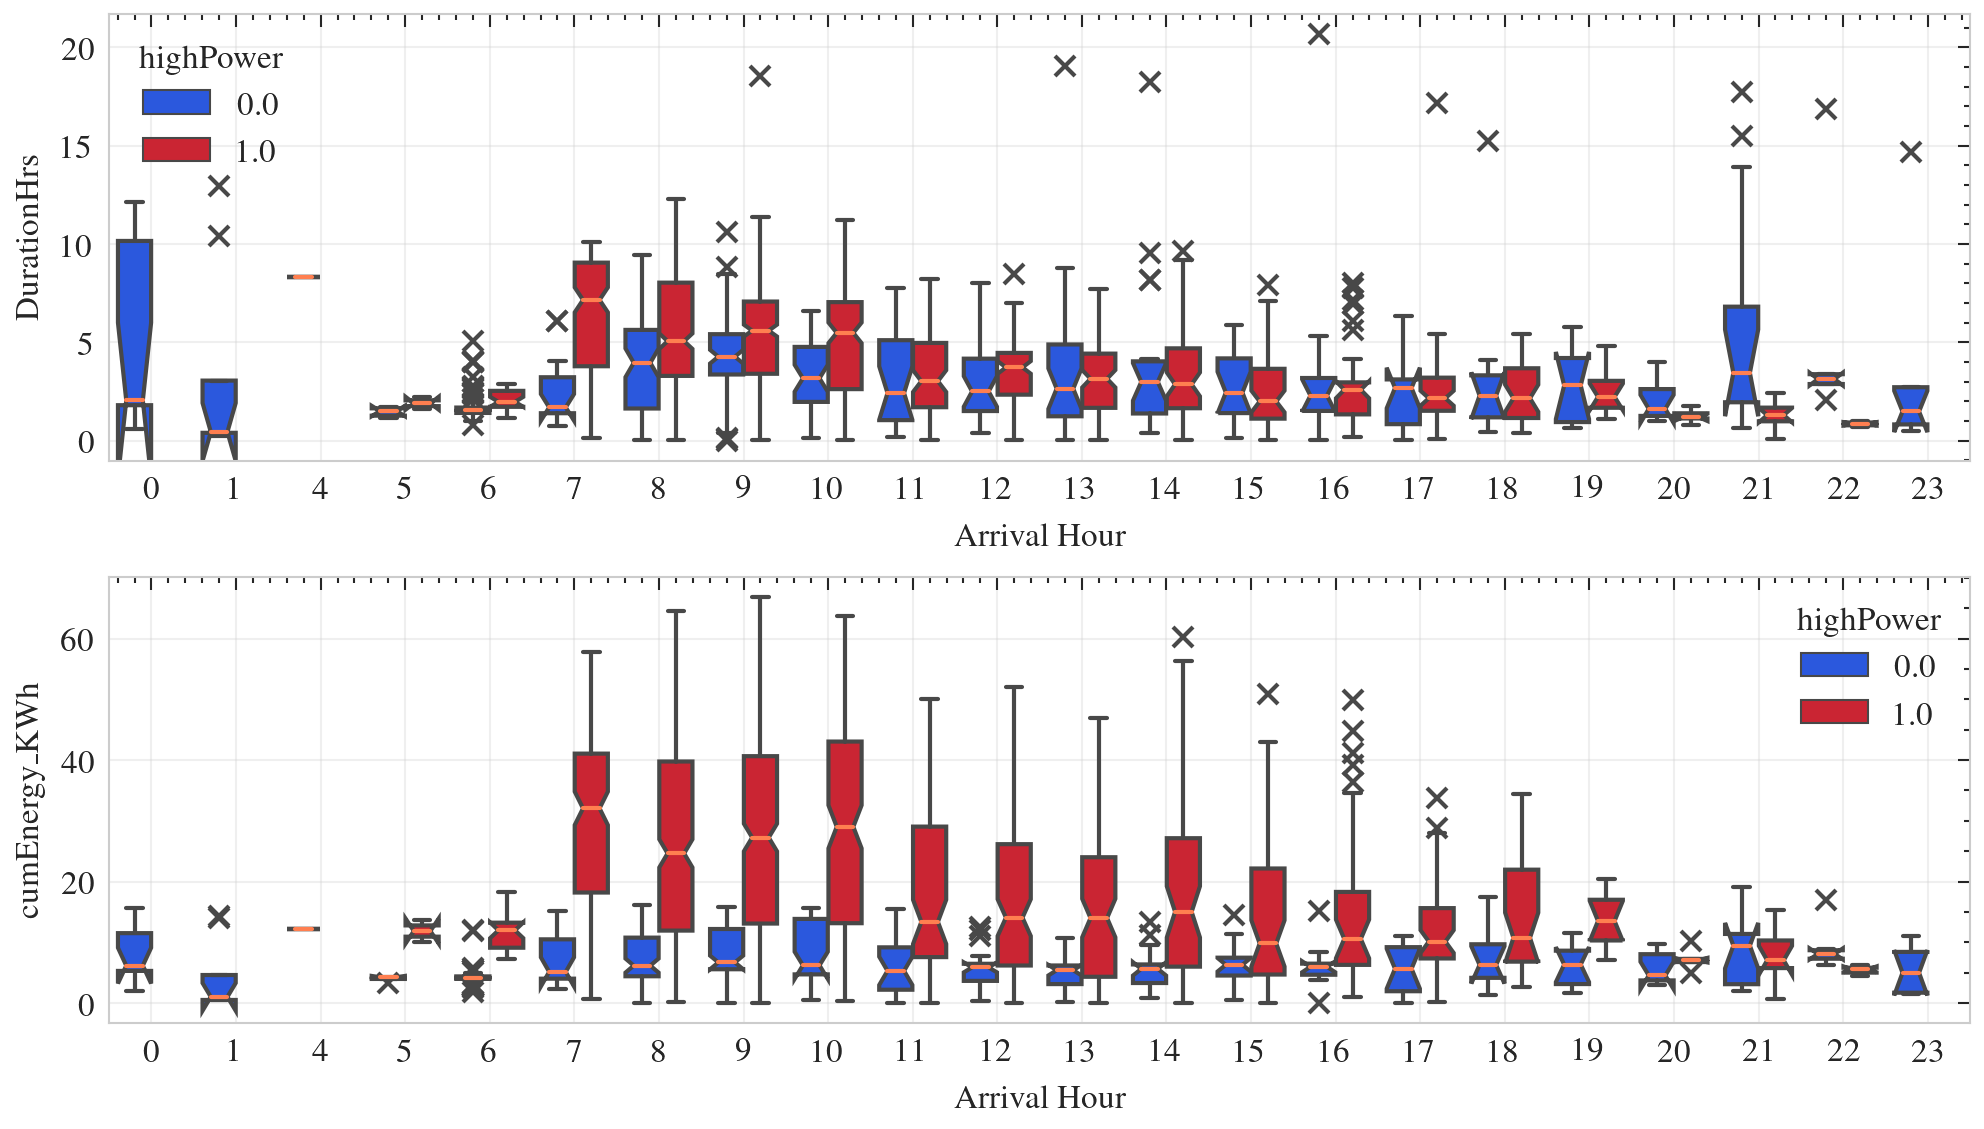

In [12]:
fig,ax= plt.subplots(2,1,figsize=( w*2, h*1.5 ))



sns.boxplot(
    data=session_df, x="arrHour", y="DurationHrs",hue='highPower',
    notch=True, showcaps=True,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},ax=ax[0]
)

sns.boxplot(
    data=session_df, x="arrHour", y="cumEnergy_KWh",hue='highPower',
    notch=True, showcaps=True,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},ax=ax[1]
)

for i in [0,1]:
    ax[i].grid(alpha=0.3)
    ax[i].set_xlabel("Arrival Hour")



In [13]:
iterables = [[0,1], range(0,24)]
idx = pd.MultiIndex.from_product(iterables, names=['highPower','arrHour'])
# pd.DataFrame(index=idx,columns = ['DurationHrs', 'cumEnergy_Wh', 'interArrivalTime_min', 'arrivalHour','cumEnergy_KWh', 'count'])
expected_demand = session_df.groupby(['highPower','arrHour']).mean()
expected_demand['count'] = session_df.groupby(['highPower','arrHour']).count()['dcosId']
expected_demand = expected_demand.reindex(idx).reset_index(drop=False)
expected_demand

C:\Users\Holiday\AppData\Local\Temp\ipykernel_18580\1708426994.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  expected_demand = session_df.groupby(['highPower','arrHour']).mean()


,highPower,arrHour,DurationHrs,cumEnergy_Wh,interArrivalTime_min,cumEnergy_KWh,userPower_kW,count
0,0,0,5.279945,8179.000000,628.065152,8.179000,3.3,11.0
1,0,1,3.232010,4157.500000,395.362500,4.157500,3.3,8.0
2,0,2,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3,NaN,NaN,NaN,NaN,NaN,NaN
4,0,4,8.323880,12213.000000,704.250000,12.213000,3.3,1.0
5,0,5,1.465440,3995.000000,1016.436667,3.995000,3.3,5.0
6,0,6,1.637458,4215.265306,988.112857,4.215265,3.3,245.0
7,0,7,2.484269,7079.333333,868.831481,7.079333,3.3,18.0
8,0,8,3.997679,7495.202703,392.400450,7.495203,3.3,74.0
9,0,9,4.323759,8331.211765,230.774510,8.331212,3.3,85.0


# Test Station Level Optimizer
Currently optimizer works only with the simulator. <br>
Start with the simple case: Run with no-on going sessions. 



Questions(Yifei):
1. What if the count of corresponding arrival hour/power level is NaN?
2. How can I retrieve the power profile of ongoing sessions?(from this dataframe? How to store the station info / define an object?)
3. Charging profile for the last control interval(only charge fractions).

In [14]:
import optimizer_station as opt
# We define the timesteps in the APP as 15 minute 
delta_t = 0.25 #hour 
print("For delta_t: ",delta_t, "max number of intervals:",24/delta_t)
################## Define the TOU Cost ##########################################
## the TOU cost is defined considering the delta_t above, if not code raises an error.##

# off-peak 0.175  cents / kwh 
TOU_tariff = np.ones((96,)) * 17.5
## 4 pm - 9 pm peak 0.367 cents / kwh 
TOU_tariff[64:84] = 36.7
## 9 am - 2 pm super off-peak 0.49 $ / kWh  to cents / kwh
TOU_tariff[36:56] = 14.9

For delta_t:  0.25 max number of intervals: 96.0


In [15]:
## Task 1: Run for 24 hours with no on going sessions 

expected_demand['sch_centsPerHr'] = pd.Series()
expected_demand['reg_centsPerHr'] = pd.Series()
expected_demand['sch_expected_power_W'] = pd.Series()
expected_demand['reg_expected_power_W'] = pd.Series()

#### TODO: YIFEI RUN OPTIMIZER FOR THE EACH ROW IN THIS DATAFRAME WITH 0 DEMAND CHARGE PENALTY ####
# ASSUME NO VEHICLES
# DON'T USE SINGLE CHARGER, ONLY USE STATION LEVEL OPTIMIZER
# When recording the powers use the same format in the sessions.csv

## Yifei: Should these parameters be fixed in the optimizer(inside) or given under different scenarios(outside the optimizer)?
par = opt.Parameters(z0 = np.array([20, 20, 1, 1]).reshape(4, 1),
                         Ts = delta_t,
                         eff = 1.0,
                         soft_v_eta = 1e-4,
                         opt_eps = 0.0001,
                         TOU = TOU_tariff)

for row in range(len(expected_demand)):

    if expected_demand.loc[row, 'DurationHrs'] > 0:
        arrival_hour = expected_demand.loc[row, 'arrHour']
        duration_hour = expected_demand.loc[row, 'DurationHrs']
        e_need = expected_demand.loc[row, 'cumEnergy_KWh']

        ### Yifei: Also do we define the event here or in the optimizer?
        event = {
            "time": int(arrival_hour / delta_t),
            "e_need": e_need,
            "duration": int(duration_hour / delta_t),
            "station_pow_max": 6.6,
            "user_power_rate": 3.3 * (expected_demand.loc[row, 'highPower'] + 1)
        }

        prb = opt.Problem(par=par, event=event)

        # Yifei: The station object, here we assume no ongoing sessions. The form of this object is not decided yet. Dict or Class?
        station = {}
        station['FLEX_list'] = list()
        station['ASAP_list'] = list()

        obj = opt.Optimization_station(par, prb, station, arrival_hour)
        station, res = obj.run_opt()
        # obj = opt.Optimization_charger(par, prb)
        # res = obj.run_opt()

        reg_centsPerHr, sch_centsPerHr = res["reg_centsPerHr"], res['sch_centsPerHr']

        expected_demand.loc[row, 'sch_centsPerHr'] = sch_centsPerHr
        expected_demand.loc[row, 'reg_centsPerHr'] = reg_centsPerHr
        # expected_demand.loc[row, 'sch_expected_power_W'] = sch_expected_power_W
        # expected_demand.loc[row, 'reg_expected_power_W'] = reg_expected_power_W
    else:
        expected_demand.loc[row, 'sch_centsPerHr'] = 0
        expected_demand.loc[row, 'reg_centsPerHr'] = 0
        # expected_demand.loc[row, 'sch_expected_power_W'] = 0
        # expected_demand.loc[row, 'reg_expected_power_W'] = 0

After 9 iterations, we got 0.000000  improvements, and claim convergence.
The prices are 20.092342 19.973519
After 16 iterations, we got 0.000000  improvements, and claim convergence.
The prices are 20.657748 20.062633
After 14 iterations, we got -0.060431  improvements, and claim convergence.
The prices are 20.638694 22.383525
After 12 iterations, we got 0.000000  improvements, and claim convergence.
The prices are 20.231731 20.046358
After 15 iterations, we got 0.000000  improvements, and claim convergence.
The prices are 20.476863 19.945635
After 13 iterations, we got 0.000000  improvements, and claim convergence.
The prices are 20.186194 19.953304
After 2 iterations, we got -0.063002  improvements, and claim convergence.
The prices are 19.950979 20.059712
After 26 iterations, we got 0.000000  improvements, and claim convergence.
The prices are 20.636064 19.965578
After 17 iterations, we got 0.000000  improvements, and claim convergence.
The prices are 20.338448 20.126020
After 21 i

AssertionError: None

In [17]:
expected_demand

,highPower,arrHour,DurationHrs,cumEnergy_Wh,interArrivalTime_min,cumEnergy_KWh,userPower_kW,count,sch_centsPerHr,reg_centsPerHr,sch_expected_power_W,reg_expected_power_W
0,0,0,5.279945,8179.000000,568.689394,8.179000,3.3,11.0,66.062137,65.968262,NaN,NaN
1,0,1,3.232010,4157.500000,379.047917,4.157500,3.3,8.0,66.470419,66.050826,NaN,NaN
2,0,2,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
3,0,3,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
4,0,4,8.323880,12213.000000,704.250000,12.213000,3.3,1.0,66.759679,67.710696,NaN,NaN
5,0,5,1.465440,3995.000000,1003.226667,3.995000,3.3,5.0,66.104637,65.959004,NaN,NaN
6,0,6,1.637458,4215.265306,993.837483,4.215265,3.3,245.0,66.449018,66.055283,NaN,NaN
7,0,7,2.484269,7079.333333,813.412037,7.079333,3.3,18.0,66.125918,65.954406,NaN,NaN
8,0,8,4.010741,7462.328767,350.924658,7.462329,3.3,73.0,66.216965,66.397767,NaN,NaN
9,0,9,4.323759,8331.211765,230.210784,8.331212,3.3,85.0,66.189891,65.940642,NaN,NaN


In [12]:
## Task 2: Run for 4 hours after a new vehicle arrives
######### Vehicle chooses REGULAR 

optimizer_time = pd.Timestamp(2023, 2, 7, 8)
print("Current time of the optimizer:",optimizer_time)

# find on-going sessions  --> This is not the best 

print("On-going sessions:",
      len(session_df[(session_df['endTime']>optimizer_time) & 
                     (session_df['startChargeTime']<optimizer_time)]))

#### TODO: YIFEI RUN OPTIMIZER FOR THE NEXT 4 HOURS #### 
SESSION_1 = session_df[(session_df['startChargeTime']>optimizer_time)].sort_values(by='connectTime').iloc[0]

## VEHICLE CHOOSES REGULAR
## RECORD THE REGULAR POWER PROFILE 
# session_df.loc[SESSIONS_IDX,'opt_power_W'] = pd.Series()


## Run optimization again 
### FIll price and power column ### 
expected_demand['sch_centsPerHr'] = pd.Series()
expected_demand['reg_centsPerHr'] = pd.Series()
expected_demand['expected_power_W'] = pd.Series()

Current time of the optimizer: 2023-02-07 08:00:00
On-going sessions: 0


In [13]:
session_df.loc[2289,'power']

[{'power_W': Decimal('6369'), 'timestamp': Decimal('1674074709')}]